<a href="https://colab.research.google.com/github/MadhabBarman/Epidemic-Control-Model/blob/master/SEIRD_ControlModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/MadhabBarman/Epidemic-Control-Model.git

In [ ]:
cd Epidemic-Control-Model/

In [7]:
%matplotlib inline
import numpy as np
import  matplotlib.pyplot as plt
import  pandas as pd
from scipy.integrate import odeint
from scipy.io import savemat, loadmat
import numpy.linalg as la
from matplotlib.lines import Line2D

M = 16
my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
Real_data = np.genfromtxt('data/covid-cases/case_time_series.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)


# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)
CM = CH + CW + CS + CO

my_data_nw = np.genfromtxt('data/covid-cases/india_10april.txt', delimiter='', skip_header=6)
death_case, active_case = my_data_nw[:,4], my_data_nw[:,5]

active = Real_data[:,7]
active_new = active[34:107]
death = Real_data[:,6]
death_new = death[34:107]
#save_results_to = 'C:/Users/HP/Desktop/Lat_radon/double peak/EPS_file/'

In [9]:
alpha_d = 0.05    #fractional constant      
beta  = 0.37      #rate of infection
rho = 0.75        #control parameter of H
xi = 0.29         #recovery rate from E
alpha_1 = 0.7    #fractional part of E-->Q
alpha_2 = 0.2     #fractional part of E-->A
alpha_3 = 1-(alpha_1+alpha_2)    #fractional part of E-->I
phi_qh  = 1/10    #Recovery rate of Q-->H
q = 0.1           #fractional part of Q-->H
g_as  = 0.1      #rate A-->I
d_ar  = 2./7      #Recovery rate of A
phi_sh = 1./2     #rate I-->H 
d_sr =  1./7       #Recovery rate of I
d_hr = (1-alpha_d)/10           #Recovery rate of H 
eta = alpha_d/10  #Death rate
fsa = 0.1         #Fraction of the contact matrix Cs 
fsh = 0.1        #Fraction of the contact matrix Ch 


# initial conditions
E_0 = np.zeros((M));
Q_0  = np.zeros((M))
A_0 = np.zeros((M))
I_0 = np.zeros((M));  I_0[6:13]=2;  I_0[2:6]=1
H_0  = np.zeros((M))
R_0  = np.zeros((M))
D_0  = np.zeros((M))
S_0  = Ni - (E_0+ Q_0 + A_0 + I_0 + H_0 + R_0 + D_0)

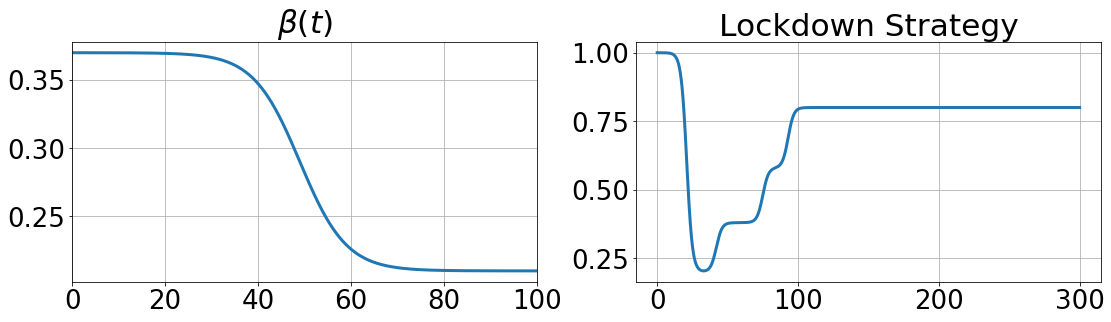

In [15]:
Tf = 300; Nf = 3000 #Tf -->final time from 0, Nf-->total number points
t = np.linspace(0,Tf,Nf)  #time span

#lockdown function
ld = lambda t, t_on, t_off, t_won, t_woff, pld: 1 + pld*0.5*(np.tanh((t - t_off)/t_woff) - np.tanh((t - t_on)/t_won))

#staggered lockdown
uc = lambda t:0.7-0.4*(np.tanh((t - 21)/4)) + 0.3*0.3*(1.0*np.tanh((t - 42)/4)-np.tanh((t - 93)/4))+\
   0.2+0.1*(np.tanh((t - 75)/4)) + 0.4*0.5*(np.tanh((t - 93)/4))


#LD2
#uc = lambda t:0.7-0.4*(np.tanh((t - 21)/4)) + 0.3*0.3*(1.0*np.tanh((t - 42)/4)-np.tanh((t - 93)/4))+\
#  0.2+0.1*(np.tanh((t - 75)/4)) + 0.4*0.5*(np.tanh((t - 93)/4)) +\
#ld(t,128, 153, 2, 2, 0.6-0.2) + ld(t,153,193, 2, 2, 0.8-0.2) + ld(t,193,233, 2, 2, 0.6-0.2)+ld(t,233,360, 2, 2, 0.4-0.2)-4.0

#LD3
#uc = lambda t:0.7-0.4*(np.tanh((t - 21)/4)) + 0.3*0.3*(1.0*np.tanh((t - 42)/4)-np.tanh((t - 93)/4))+\
#   0.2+0.1*(np.tanh((t - 75)/4)) + 0.4*0.5*(np.tanh((t - 93)/4)) +\
#ld(t,130, 160, 2, 2, 0.6-0.2)+ld(t,160, 230, 2, 2, 0.8-0.2) + ld(t,230, 300, 2, 2, 0.6-0.2) + ld(t,300, 420, 2, 2, 0.4-0.2)   - 4.0

beta_max, k, t_m, beta_min = beta, 0.2, 49, 0.21 # 
def beta_f(t):
    return ((beta_max-beta_min) / (1 + np.exp(-k*(-t+t_m))) + beta_min)

plt.figure(figsize=(16,5))
plt.rcParams['font.size']=26
plt.subplot(1,2,1)
plt.plot(t,beta_f(t),lw=3);
plt.title(r'$\beta(t)$')
plt.grid(True)
plt.xlim(0,100);
plt.subplot(1,2,2)
plt.plot(t, uc(t),lw=3)
plt.title('Lockdown Strategy')
plt.tight_layout(True)
plt.grid(True)

In [11]:
def cont(t):
    return CH  + uc(t)*(CW + CO + CS)
    #return CM

#  S=y[i], E=y[M+i], Q=y[2M+i],A=y[3M+i], I=y[4M+i], H=y[5M+i], R=y[6M+i] for i=1,2,3,...,M

dy = np.zeros(7*M)
def rhs(y, t, cont, beta_f):
    CM = cont(t)  #contact matrix
    for i in range(M):
        lmda=0
        for j in range(M):
            lmda += beta_f(t)*(CM[i,j]*y[3*M+j] + fsa*CM[i,j]*y[4*M+j] +fsh*(1.0-rho)*CM[i,j]*y[5*M+j])/Ni[j]   
        dy[i]     = - lmda*y[i]  + (1-q)*phi_qh*y[2*M+i]   # S susceptibles
        dy[i+M]   =   lmda*y[i]  - xi*y[M+i]   #E exposed class 
        dy[i+2*M] = alpha_1*xi*y[M+i] - phi_qh*y[2*M+i]   #Q Quarantined 
        dy[i+3*M] = alpha_2*xi*y[M+i] - (g_as + d_ar )*y[3*M+i]     #A Asymptomatic infected 
        dy[i+4*M] = alpha_3*xi*y[M+i] + g_as*y[3*M+i] - (phi_sh + d_sr)*y[4*M+i]  #I Symptomatic infected 
        dy[i+5*M] = phi_sh*y[4*M+i] + q*phi_qh*y[2*M+i] - (d_hr + eta)*y[5*M+i]  #H Isolated
        dy[i+6*M] = d_ar*y[3*M+i] + d_sr*y[4*M+i] + d_hr*y[5*M+i]  #Recovered
    return dy
        
data = odeint(rhs, np.concatenate((S_0, E_0, Q_0, A_0, I_0, H_0, R_0)), t, args=(cont,beta_f))
tempS, tempE, tempQ, tempA, tempI, tempH, tempR = np.zeros((Nf)),\
np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf))
for i in range(M):
    tempS += data[:, 0*M + i]
    tempE += data[:, 1*M + i]
    tempQ += data[:, 2*M + i]
    tempA += data[:, 3*M + i]
    tempI += data[:, 4*M + i]
    tempH += data[:, 5*M + i]
    tempR += data[:, 6*M + i]
IC_death = N - (tempS + tempE + tempQ + tempA + tempI + tempH + tempR)

**Simulated individuals figure**

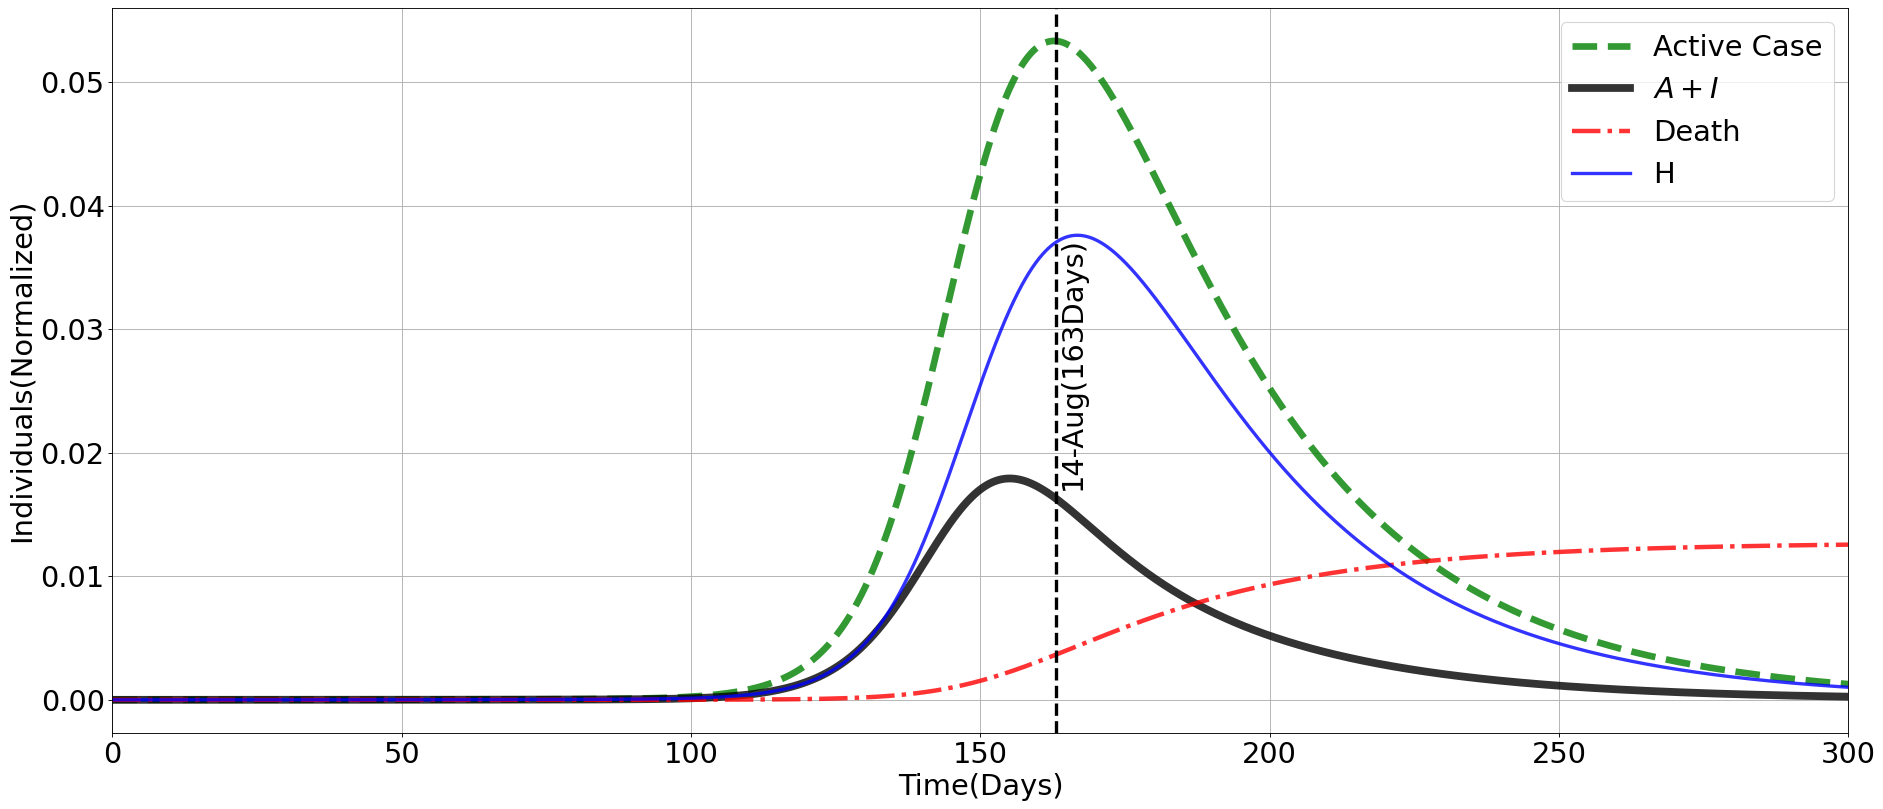

In [16]:
fig = plt.figure(num=None, figsize=(28, 12), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})
plt.plot(t, (tempA + tempI + tempH)/N, '--', lw=6, color='g', label='Active Case', alpha=0.8)
plt.plot(t, (tempA + tempI)/N , '-', lw=7, color='k', label='$A + I$', alpha=0.8)
plt.plot(t, IC_death/N, '-.', lw=4, color='r', label='Death', alpha=0.8)
plt.plot(t, tempH/N, '-', lw=3, color='b', label='H', alpha=0.8)
plt.legend(fontsize=26, loc='best'); plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Individuals(Normalized)');
plt.text(163.5,0.0175,'14-Aug(163Days)',rotation=90)
plt.xlim(0,300);
plt.xlabel('Time(Days)')
plt.axvline(163,c='k',lw=3,ls='--');
#plt.savefig(save_results_to+'Figure10.png', format='png', dpi=200)

**Analysis between real case data vs numerical**

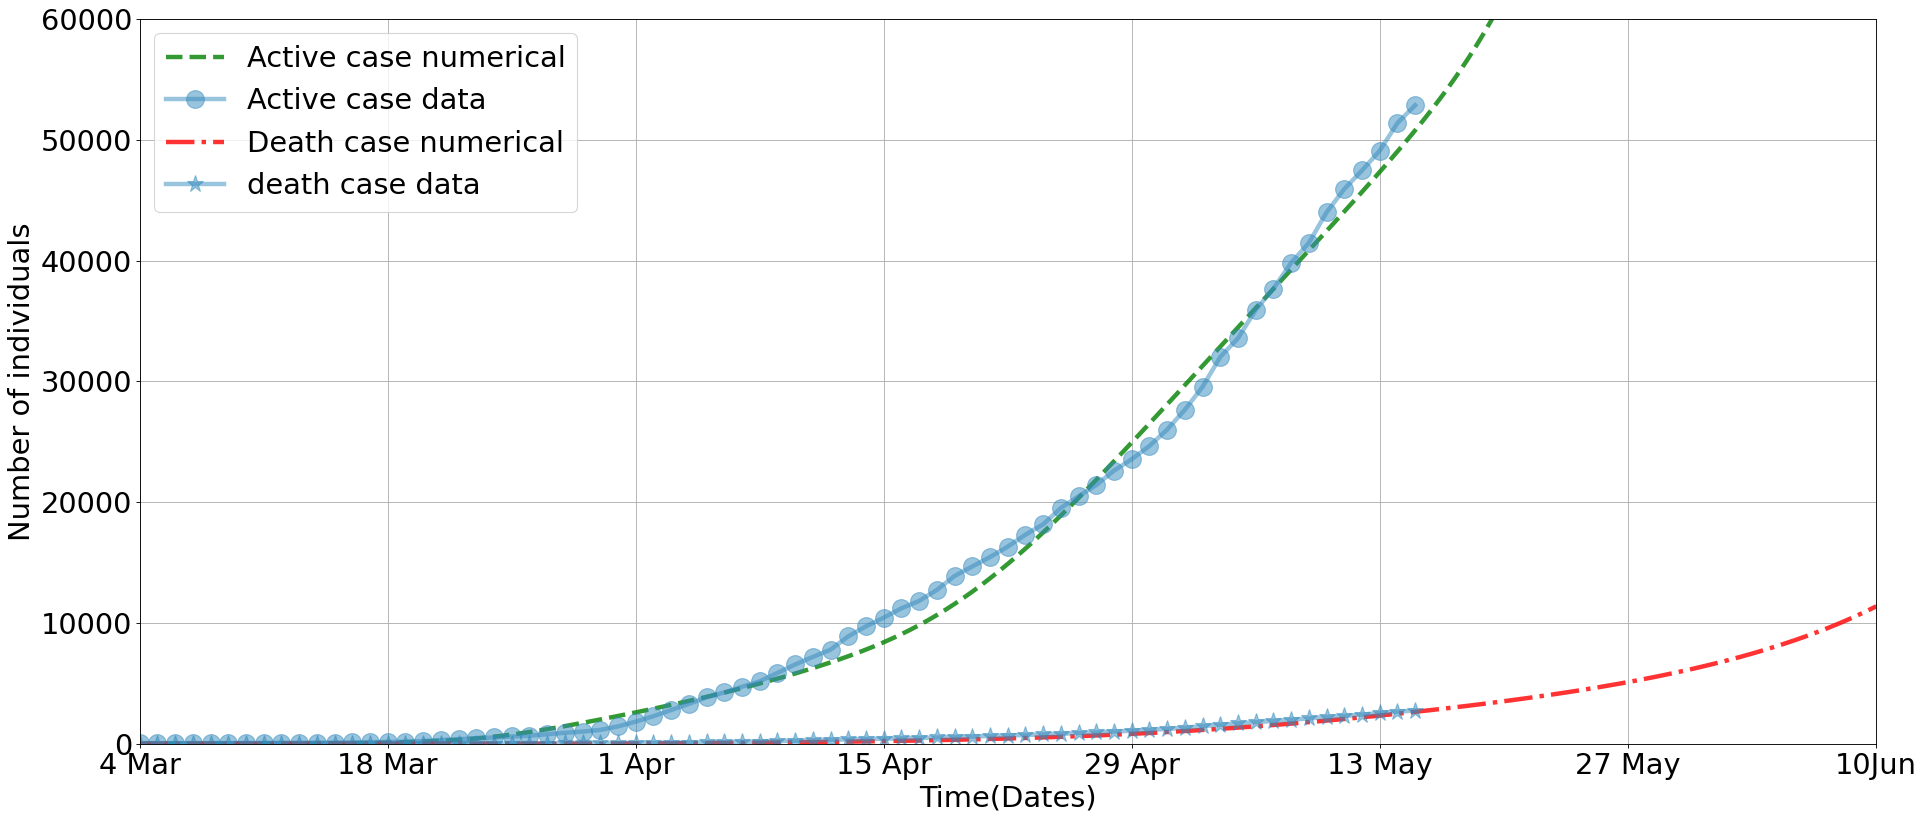

In [17]:
fig = plt.figure(num=None, figsize=(28, 12), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26, 'text.color':'black'})
plt.plot(t, tempA + tempI + tempH, '--', lw=4, color='g', label='Active case numerical', alpha=0.8)
plt.plot(active_new, 'o-', lw=4, color='#348ABD', ms=16, label='Active case data', alpha=0.5)
plt.plot(t, IC_death, '-.', lw=4, color='r', label='Death case numerical', alpha=0.8)
plt.plot(death_new, '-*', lw=4, color='#348ABD', ms=16, label='death case data', alpha=0.5)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun','24Jun'));
plt.legend(fontsize=26, loc='best'); plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Number of individuals');
plt.xlabel('Time(Dates)')
plt.ylim(0, 60000);
plt.xlim(0, 98);

**Sensitivity of hospitalization parameter $\rho$**

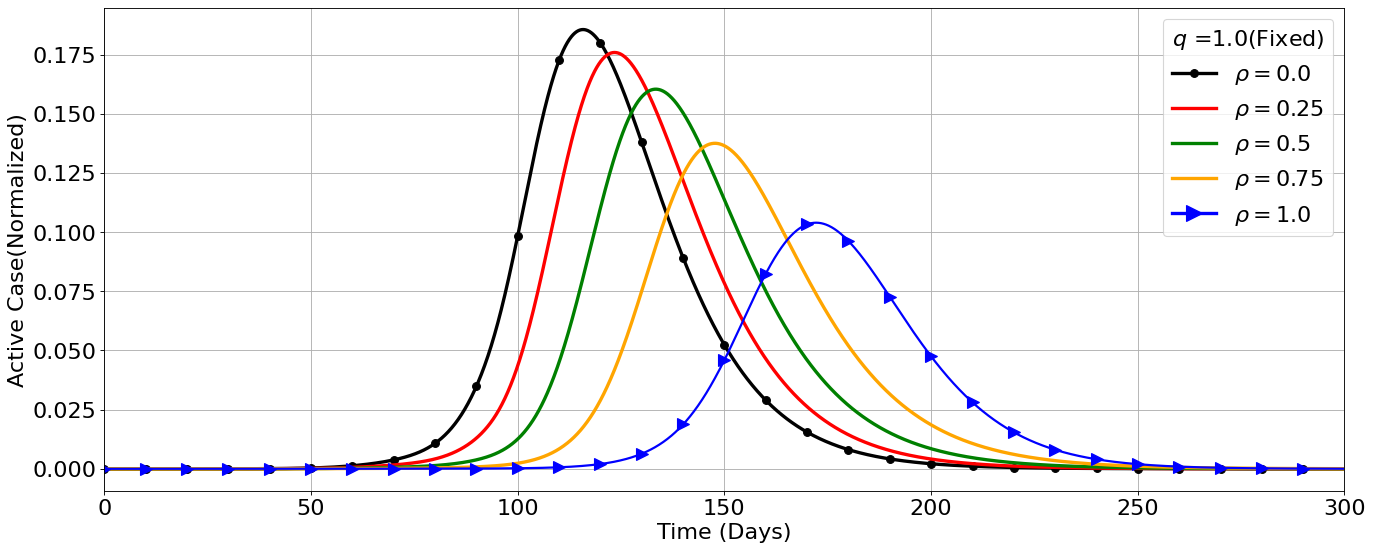

In [21]:
q = 1.0
rhos = [0.0, 0.25, 0.5, 0.75, 1.0]
fig = plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 20})
for rho in rhos:
    data = odeint(rhs, np.concatenate((S_0, E_0, Q_0, A_0, I_0, H_0, R_0)), t, args=(cont,beta_f))
    tempS, tempE,  tempQ, tempA, tempI, tempH, tempR = np.zeros((Nf)),\
    np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf))
    for i in range(M):
        tempA += data[:, 3 * M + i]
        tempI += data[:, 4 * M + i]
        tempH  += data[:, 5 * M + i]
    if rho==1.0:
            yy = tempA/N + tempI/N + tempH/N
            plt.plot(t,yy, lw = 2, ls='-',c='b', label=r'$\rho = $' + str(rho))
            plt.plot(t[::100],yy[::100],  '>', label=None, markersize=11, c='b')
    elif rho==0.75:    
            plt.plot(t,tempA/N + tempI/N + tempH/N, lw = 3, c='orange')
    elif rho==0.5:    
            plt.plot(t,tempA/N + tempI/N + tempH/N, lw = 3, c='g')
    elif rho==0.25:    
            plt.plot(t,tempA/N + tempI/N + tempH/N, lw = 3, c='r')
    else:
        yy = tempA/N + tempI/N + tempH/N
        plt.plot(t,tempA/N + tempI/N + tempH/N, lw = 3, ls='-', c='k')
        plt.plot(t[::100],yy[::100],  '.', label=None, markersize=14, c='k')
plt.ylabel('Active Case(Normalized)');
plt.xlabel('Time (Days)');
plt.autoscale(enable=True, axis='x',tight=True)
plt.grid(True)
colors = ['k', 'r','g','orange', 'b']
marker = ['.', None, None, None, '>']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-',marker=r, markersize=14) for (c,r) in zip(colors,marker)]
labels = [r'$\rho=0.0$',r'$\rho=0.25$',r'$\rho=0.5$',r'$\rho=0.75$',r'$\rho=1.0$']
plt.legend(lines, labels,title=r'$q$ ='+str(q)+'(Fixed)')
#plt.savefig('rho_var1.png', format='png',dpi=200)
#plt.savefig(save_results_to+'Figure08.png', format='png',dpi=200)

**Sensitivity of quarantine parameter $q$**

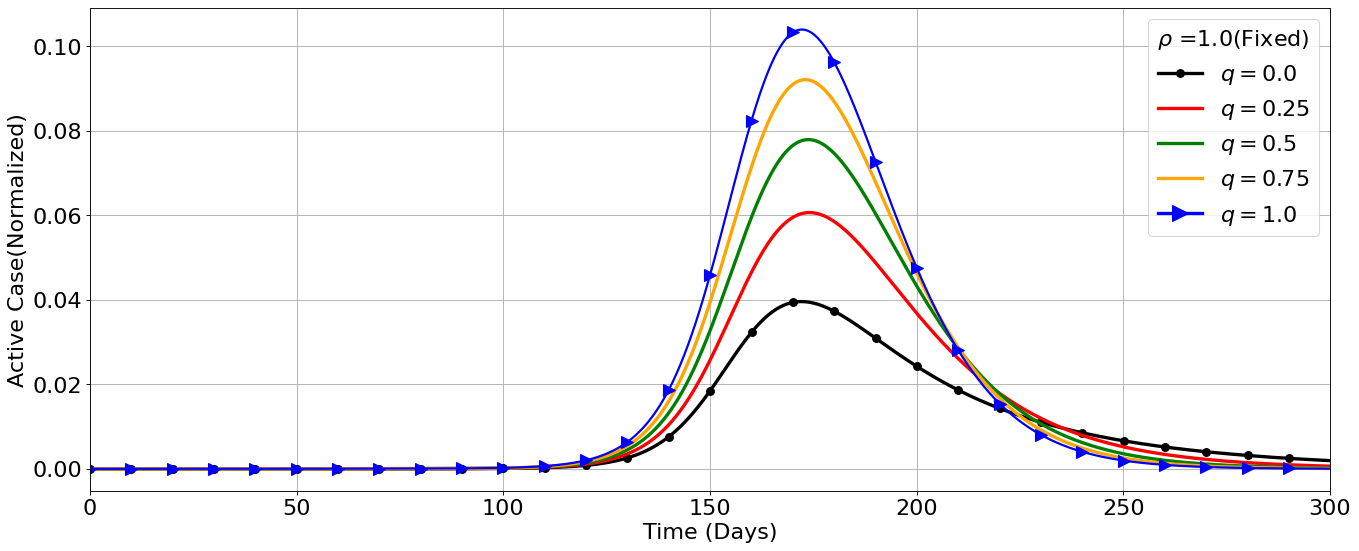

In [22]:
rho = 1.0
qs = [0.0, 0.25, 0.5, 0.75, 1.0]
fig = plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 20})
for q in qs:
    data = odeint(rhs, np.concatenate((S_0, E_0, Q_0, A_0, I_0, H_0, R_0)), t, args=(cont,beta_f))
    tempS, tempE,  tempQ, tempA, tempI, tempH, tempR = np.zeros((Nf)),\
    np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf))
    for i in range(M):
        tempA += data[:, 3 * M + i]
        tempI += data[:, 4 * M + i]
        tempH  += data[:, 5 * M + i]
    if q==1.0:
            yy = tempA/N + tempI/N + tempH/N
            plt.plot(t,yy, lw = 2, ls='-',c='b')
            plt.plot(t[::100],yy[::100],  '>', label=None, markersize=11, c='b')
    elif q==0.75:    
            plt.plot(t,tempA/N + tempI/N + tempH/N, lw = 3, c='orange')
    elif q==0.5:    
            plt.plot(t,tempA/N + tempI/N + tempH/N, lw = 3, c='g')
    elif q==0.25:    
            plt.plot(t,tempA/N + tempI/N + tempH/N, lw = 3, c='r')
    else:
        yy = tempA/N + tempI/N + tempH/N
        plt.plot(t,tempA/N + tempI/N + tempH/N, lw = 3, ls='-', c='k')
        plt.plot(t[::100],yy[::100],  '.', label=None, markersize=14, c='k')
plt.ylabel('Active Case(Normalized)');
plt.xlabel('Time (Days)');
plt.autoscale(enable=True, axis='x',tight=True)
plt.grid(True)
colors = ['k','r','g','orange','b']
marker = ['.', None, None, None, '>']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-',marker=r, markersize=14) for (c,r) in zip(colors,marker)]
labels = [r'$q=0.0$',r'$q=0.25$',r'$q=0.5$',r'$q=0.75$',r'$q=1.0$']
plt.legend(lines, labels,title=r'$\rho$ ='+str(rho)+'(Fixed)')
#plt.savefig('q_var1.png', format='png',dpi=200)
#plt.savefig(save_results_to+'Figure07.png', format='png',dpi=200)